---
title: 'Lab03: Digit Recognition with Clustering'
subtitle: "MSDS 7331"
authors: "Anthony Burton-Cordova, Will Jones, Nick Sager"
date: November 9, 2023
jupyter: python3
---

## Business Understanding

The data we are working with is part of the Modified National Institute of Standards and Technology (MNIST) digit recognition dataset for computer vision. The version we are using for this project is available from on [Kaggle](https://www.kaggle.com/competitions/digit-recognizer/overview).

The MNIST dataset contains a large collection of 28x28 pixel grayscale images of handwritten digits (0 through 9). This dataset is very commonly used in machine learning, and the objective is to correctly classify the digit in each image. Identifying handwritten digits is a common problem in many business use cases; a classifier could be used to automatically read addresses on envelopes, to read handwritten numbers on bank checks for mobile deposit, or to help grade tests in an educational setting.

For this project, we set out to explore the MNIST dataset using clustering techniques. Labels are available for this data, which makes it a good candidate for many other machine learning techniques. For example, the viability of Neural Networks for classifying digits has bee well documented. In practice, labelling tens of thousands of handwritten digits may time and cost prohibitive. We believe that clustering has the potential to identify groups of similar digits, which could be more easily and efficiently labelled. This would allow generalization of handwriting recognition outside of digits, and even the English language. Labelling in this way could then serve as a preprocessing step for training more complex models. 

To evaluate our clustering analysis we will primarily use accuracy after manually labelling the clusters. Neural Networks regularly achieve accuracies of more than 99% on this dataset [@MNIST]. We do not expect to achieve this level of accuracy, but we do expect to be able to identify clusters of digits with similar characteristics. The clusters will also be evaluated for separation in order to judge the feasibility of using them as a preprocessing step for other machine learning techniques.

## Data Understanding


In [103]:
import pandas as pd

# Choose File
RawBank = "https://raw.githubusercontent.com/NickSager/DS7331_Projects/main/Lab01/data/bank-additional-full.csv"
#RawBank = "data/bank-additional-full.csv"

# Read the CSV file with a semicolon ; separator
bank = pd.read_csv(RawBank, sep=';')

# Get info on the dataset
print(bank.info())
bank.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


## Data Preparation

NA values are coded as 'unknown', 'nonexistent', or 999 in the dataset. We will need to convert these to NA in order to determine how many are missing and how to handle them.

In [104]:
import numpy as np

# let's set those values to NaN, so that Pandas understand they are missing
df = bank.copy() # make a copy of the dataframe
df = df.replace(to_replace = 'unknown', value = np.nan) # replace unknown with NaN (not a number)
df = df.replace(to_replace = 999, value = np.nan) # replace 999 with NaN (not a number)
df = df.replace(to_replace = 'nonexistent', value = np.nan) # replace nonexistent with NaN (not a number)

print (df.info())
df.describe() # scroll over to see the values

# From course material "01. Pandas.ibynb"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             40858 non-null  object 
 2   marital         41108 non-null  object 
 3   education       39457 non-null  object 
 4   default         32591 non-null  object 
 5   housing         40198 non-null  object 
 6   loan            40198 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41186 non-null  float64
 11  campaign        41188 non-null  int64  
 12  pdays           1515 non-null   float64
 13  previous        41188 non-null  int64  
 14  poutcome        5625 non-null   object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41186.000000,41188.000000,1515.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.249041,2.567593,6.014521,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.234158,2.770014,3.824906,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,3.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,6.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,7.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,27.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


With the exception of Days Elapsed and two missing values in Duration, the numerical data is complete. We will change the two entries with 999s duration back to 999s in case they don't represent an entry error. Based on the maximum duration, that value isn't necessarily an outlier. The amount of non-null Days Elapsed values is actually very small (3.7% of total records). This means that the vast majority of cases represent the first call of the current marketing campaign.

Of the categorical values, Previous Outcome, Job, Marital Status, Education, and Default have missing values. There are also roughly 1000 records which have missing values for both housing and personal loan. Previous outcome has the most missing values (13.7% non-null), which is in agreement with our assumption that most of the records represent the first call of the current marketing campaign. 

One can imagine that some clients could have jobs that don't fit into the categories provided. Rather than exclude these records, we will change the NA's back to 'unknown' and treat this as it's own category. We will do the same for Marital Status and Education. For default, housing, and personal loan, we will assume that the missing values indicate that the client does not have a loan or credit in default. We will change the NA's to 'no' for these features, assuming that the presence of any of these is easier to find than the absence.

Previous outcome is a little more difficult to handle. One option would be to change it to a binary variable indicating "success" or "not success". However, success in a previous marketing campaign probably does provide important information about the client. We will change the NA's to "not contacted" and treat it as it's own category. This category will be largely ignored in the analysis, but will be included in predictive models to avoid losing information. NA's in the days elapsed feature will be changed to the mean value of the non-null records.

In [105]:
# Change NA Categoricals to 'unknown'
df['job'] = df['job'].fillna('unknown')
df['marital'] = df['marital'].fillna('unknown')
df['education'] = df['education'].fillna('unknown')

# Change NA Credit history values to 'no'
df['default'] = df['default'].fillna('no')
df['housing'] = df['housing'].fillna('no')
df['loan'] = df['loan'].fillna('no')

# Change NA Previous Outcome to 'not contacted'
df['poutcome'] = df['poutcome'].fillna('not contacted')

# Change NA pdays to the mean
df['pdays'] = df['pdays'].fillna(df['pdays'].mean())

# Change NA Duration to '999'
df['duration'] = df['duration'].fillna(999)

print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  float64
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  float64
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,6.014521,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,0.733337,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,6.014521,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,6.014521,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,6.014521,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,27.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


There are now 41188 records in the dataset without missing values. The summary statistics appear similar with the exception of days elapsed. We will consider removing this feature later on, as 96% of it represents an imputed value.

## Simple Statistics


In [106]:
#Stats on the data
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,6.014521,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,0.733337,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,6.014521,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,6.014521,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,6.014521,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,27.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


The table above shows summary statistics for the numerical features in the dataset. Most clients are between 20 and 60 years old, and have been contacted 2.5 times during the campaign. Most clients have not been contacted in previous campaigns. The economic features show the range of values during this study, and can be used to gauge the strength of the Portuguese economy at the time of contact. Although duration will not be used for prediction, the mean duration is 258 seconds, or about 4.3 minutes. Interestingly, the standard deviation is 259 seconds, which suggests that a large proportion of clients either didn't answer or hung up very quickly.

In [107]:
# Calculate the percentage of people who subscribed to a term deposit
len(df[df.y == 'yes']) / len(df) * 100.0

11.265417111780131

Of the clients targeted by this campaign, 11.3% subscribed to the term deposit. The dataset is imbalanced, which will have to be taken into account when building and evaluating predictive models.

In [108]:
df.groupby(by='y').median(numeric_only = True)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
no,38.0,163.5,2.0,6.014521,0.0,1.1,93.918,-41.8,4.857,5195.8
yes,37.0,449.0,2.0,6.014521,0.0,-1.8,93.200,-40.4,1.266,5099.1


We can see a few differences between the clients who subscribed to the term deposit and those who did not by looking at the median of the numeric variables. The median age of those who subscribed is slightly lower than those who did not. The median duration of phone call was much higher for those who subscribed, although we will exclude this feature in predictive models.

The socioeconomic variables all show differences between the groups, suggesting that economic conditions may be a factor in a client's decision whether to subscribe or not. More analysis is necessary to test whether these differences are significant, but we expect these variables to be important predictors.

In [109]:
# Create a numeric version of the y variable where yes = 1 and no = 0
df['y_num'] = df['y'].map({'yes': 1, 'no': 0})

# Lets aggregate by job and count subscription rates
df_grouped = df.groupby(by='job')
print ('---------------------------------------')
print('Count by Job:')
print (df_grouped.y_num.count())
print ('---------------------------------------')
print('Subscription Rate by Job:')
print (df_grouped.y_num.sum() / df_grouped.y_num.count())

# Adapted from Course material "02. Data Visualization.ipynb"

---------------------------------------
Count by Job:
job
admin.           10422
blue-collar       9254
entrepreneur      1456
housemaid         1060
management        2924
retired           1720
self-employed     1421
services          3969
student            875
technician        6743
unemployed        1014
unknown            330
Name: y_num, dtype: int64
---------------------------------------
Subscription Rate by Job:
job
admin.           0.129726
blue-collar      0.068943
entrepreneur     0.085165
housemaid        0.100000
management       0.112175
retired          0.252326
self-employed    0.104856
services         0.081381
student          0.314286
technician       0.108260
unemployed       0.142012
unknown          0.112121
Name: y_num, dtype: float64


The plurality of jobs are of type 'Admin.' and 'Blue-Collar'. We can see that there are large variations in average subscription rates by job type. Retired people and Students appear much more likely to subscribe, while blue-collar workers are appear less likely.

In [110]:
# let's break up the age variable
df['age_range'] = pd.cut(df.age,[0,40,60,1e6],3,labels=['Young','Middle-Age','Old']) # this creates a new variable
df.age_range.describe()

count     41188
unique        3
top       Young
freq      23768
Name: age_range, dtype: object

In [111]:
# now lets group with the new variable
df_grouped = df.groupby(by=['age_range'])
print ("Percentage of subscribers in each group:")
print (df_grouped.y_num.sum() / df_grouped.y_num.count() *100)

Percentage of subscribers in each group:
age_range
Young         11.448166
Middle-Age     9.115687
Old           45.494505
Name: y_num, dtype: float64


Based on the grouping, it appears that Middle-aged people are the least likely to subscribe and old people are the most likely by a large margin. This suggests that age is a significant factor in whether a client subscribes to the term deposit.

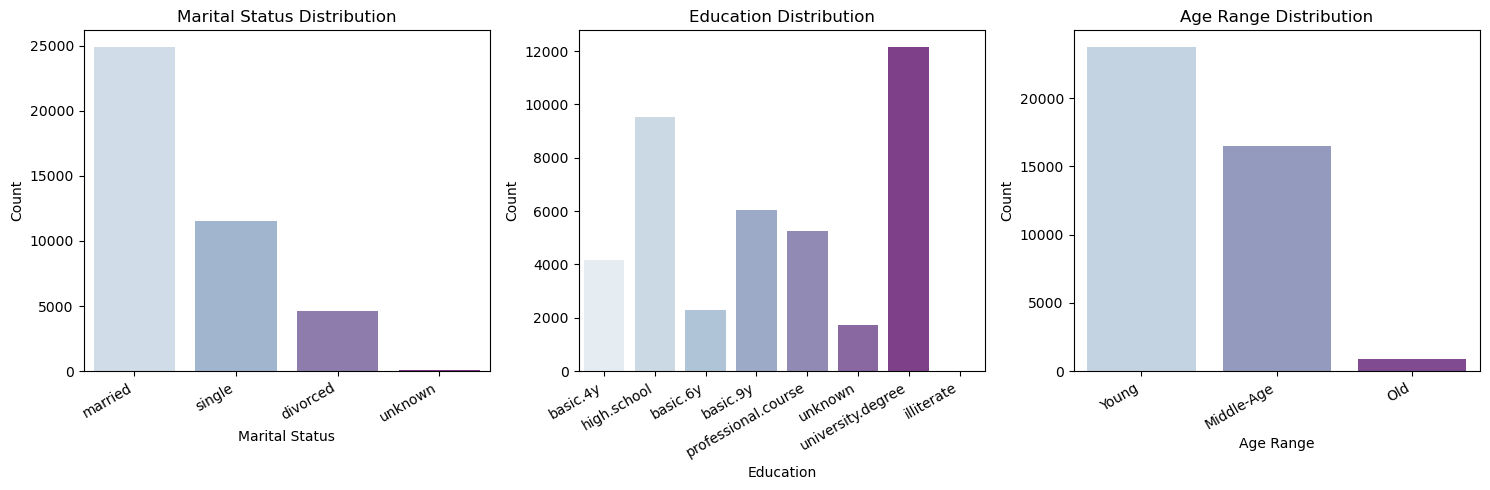

In [112]:
# Visualize proportions of marital status, education, and age range
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
f, axes = plt.subplots(1, 3, figsize=(15, 5))

# Graph Matital Status
sns.countplot(x="marital", data=df, palette="BuPu", ax=axes[0])
axes[0].set_xlabel('Marital Status')
axes[0].set_ylabel('Count')
axes[0].set_title('Marital Status Distribution')

# Graph Education Distribution
sns.countplot(x="education", data=df, palette="BuPu", ax=axes[1])
axes[1].set_xlabel('Education')
axes[1].set_ylabel('Count')
axes[1].set_title('Education Distribution')

# Graph Age Range Distribution
sns.countplot(x="age_range", data=df, palette="BuPu", ax=axes[2])
axes[2].set_xlabel('Age Range')
axes[2].set_ylabel('Count')
axes[2].set_title('Age Range Distribution')

plt.setp(axes[0].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(axes[1].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(axes[2].get_xticklabels(), rotation=30, horizontalalignment='right')

plt.tight_layout()  # Adjust layout so labels do not overlap
plt.show()

The majority of clients are married, with an slightly smaller portion being single or divorced. Most clients have a university degree or high school diploma. There are very few with unknown or illiterate education status, and a fair number with basic education. The largest age group is Young Adults (17-40), followed by Middle-Age (40-60). There are very few clients over 60, although as previously discussed, this group has very high subscription rates and is expected to be a strong predictor.

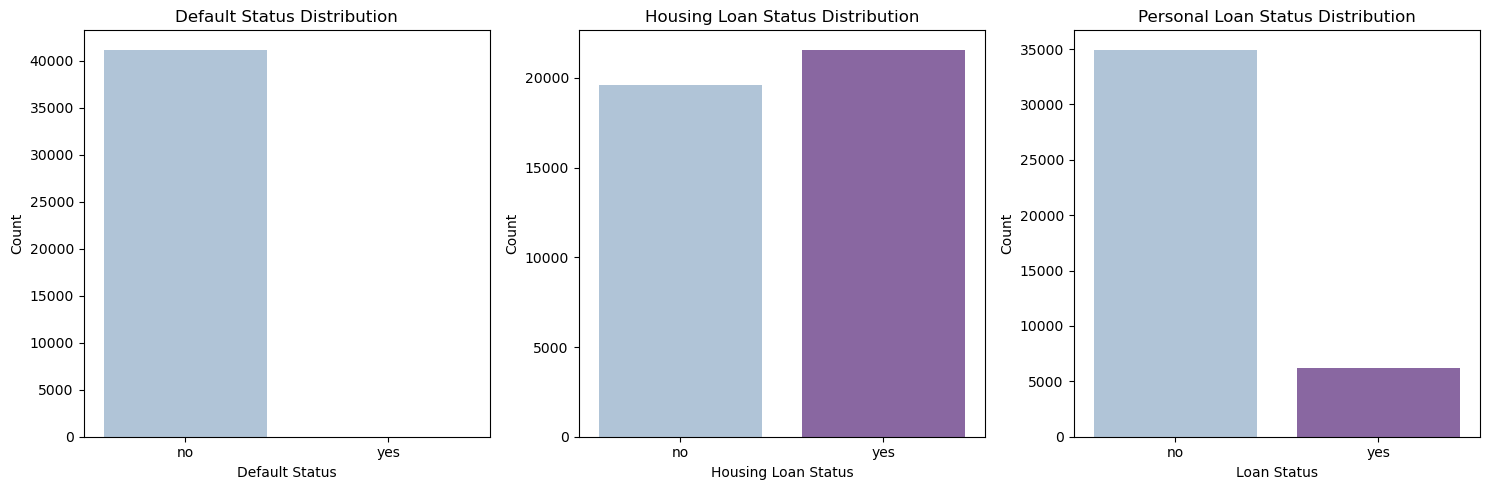

In [113]:
# Visualize proportions of loan status
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
f, axes = plt.subplots(1, 3, figsize=(15, 5))

# Graph Default Distribution
sns.countplot(x="default", data=df, palette="BuPu", ax=axes[0])
axes[0].set_xlabel('Default Status')
axes[0].set_ylabel('Count')
axes[0].set_title('Default Status Distribution')


# Graph Housing Loan Distribution
sns.countplot(x="housing", data=df, palette="BuPu", ax=axes[1])
axes[1].set_xlabel('Housing Loan Status')
axes[1].set_ylabel('Count')
axes[1].set_title('Housing Loan Status Distribution')

# Graph Personal Loan Distribution
sns.countplot(x="loan", data=df, palette="BuPu", ax=axes[2])
axes[2].set_xlabel('Loan Status')
axes[2].set_ylabel('Count')
axes[2].set_title('Personal Loan Status Distribution')

plt.tight_layout()  # Adjust layout so labels do not overlap
plt.show()

Exploring loan and credit status, we can see that almost none of the clients have credit in default. Housing loans are approximately equally distributed, with slightly more clients having a mortgage. There is a small but significant proportion of clients which have a personal loan.

## Modeling

## Evaluation

## Deployment

## Exceptional Work

In order to narrow down the number of features used for prediction, we will use Principal Component Analysis (PCA) to capture most of the variability. Additionally, the makeup of the most important principal components will provide insight into which features are most important for prediction.

The code in this section is adopted from the course material in the notebook '03. Dimension Reduction.ipynb'.

In [123]:
# Convert all features to numeric using dummy variables
df_numeric = pd.get_dummies(df, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'age_range'], drop_first=True)

df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   duration                       41188 non-null  float64
 2   campaign                       41188 non-null  int64  
 3   pdays                          41188 non-null  float64
 4   previous                       41188 non-null  int64  
 5   emp.var.rate                   41188 non-null  float64
 6   cons.price.idx                 41188 non-null  float64
 7   cons.conf.idx                  41188 non-null  float64
 8   euribor3m                      41188 non-null  float64
 9   nr.employed                    41188 non-null  float64
 10  y                              41188 non-null  object 
 11  y_num                          41188 non-null  int64  
 12  job_blue-collar                41188 non-null 

PCA requires all features to be numeric, so we have converted the categorical features to dummy variables. This will also be useful to have for certain predictive models.

In [124]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Separate target and features
X = df_numeric.drop(columns=['y', 'y_num']).values  # Dropping the target column and converting to numpy array
y = df_numeric['y_num'].values

pca = PCA(n_components=2)
X_pca = pca.fit(X).transform(X) # fit data and then transform it

lda = LDA(n_components=1)
X_lda = lda.fit(X, y).transform(X) # fit data and then transform it

# print the components

print ('pca:', pca.components_)
print ('lda:', lda.scalings_.T)

pca: [[-3.21755198e-05  9.99908457e-01 -7.71684091e-04  4.11509413e-05
   4.29913966e-05 -1.90114468e-04  7.46452339e-06 -1.52663133e-04
  -2.43823741e-04 -1.35034439e-02  2.05211822e-05  2.55371635e-06
  -3.06170941e-06 -1.28980044e-06  9.95607520e-06  2.97992047e-06
   7.39234196e-08  8.37076935e-06 -1.98896001e-05 -3.18525325e-06
  -2.22691359e-06 -8.20468045e-06  1.41999325e-05  1.57628395e-06
   4.98676162e-06  6.40823301e-06  9.03399322e-06  1.19772714e-07
  -1.09674714e-05 -2.20123483e-05  2.62906249e-06 -1.68580837e-07
  -1.27748246e-05  1.45742999e-07 -5.13766345e-05 -5.86761386e-05
   5.85848053e-06  3.75731949e-05 -3.09830188e-05 -2.13483625e-06
   1.58272283e-05 -1.85236659e-05  8.31800327e-06  8.60846451e-06
  -3.59163642e-05  2.30234031e-05  6.28435670e-06  2.21811735e-05
  -1.79050883e-05  3.19759471e-05 -6.84161396e-06  5.71303891e-06]
 [ 2.60886823e-03 -1.35112008e-02 -5.40725125e-03  1.85767860e-04
   3.43252326e-03 -1.97256813e-02 -4.19306230e-03 -6.45538022e-03
  -2

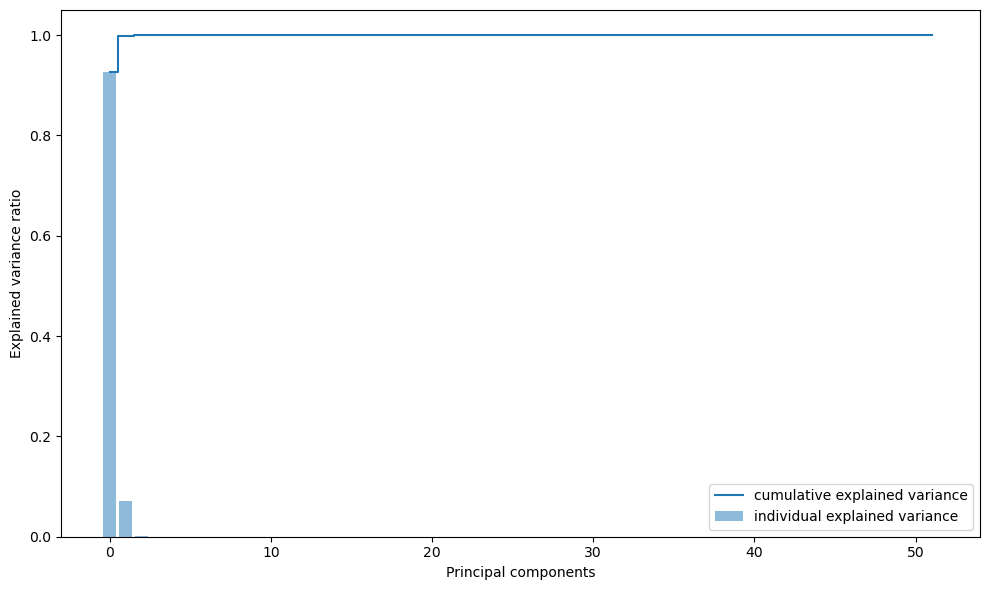

In [125]:
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(X)

explained_var = pca.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)

plt.figure(figsize=(10, 6))
plt.bar(range(len(explained_var)), explained_var, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(len(cum_explained_var)), cum_explained_var, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

We can see that the first principal component explains almost all of the variance. Looking at the coefficients, we can see that 'Duration' is the most important factor by almost two orders of magnitude. As discussed earlier, this isn't really a valid predictor but it is interesting to see just how much it is correlated with subscriptions.

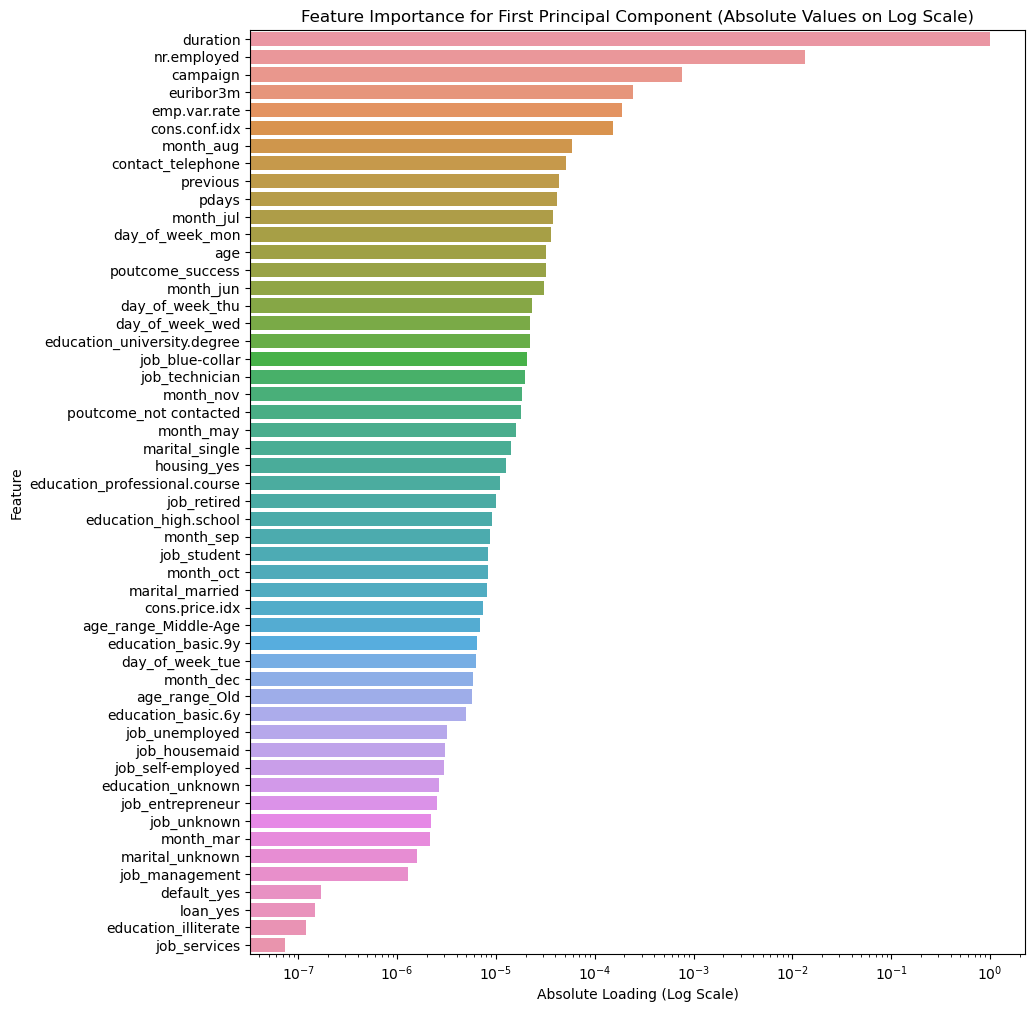

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract weights (loadings) for the first principal component
loadings = pca.components_[0]

# Create a DataFrame for the loadings
feature_names = df_numeric.drop(columns=['y', 'y_num']).columns.tolist()
df_loadings = pd.DataFrame({'feature': feature_names, 'loading': loadings})

# Sort DataFrame by the absolute value of the loading for better visualization
df_loadings['abs_loading'] = df_loadings['loading'].abs()
df_loadings = df_loadings.sort_values(by='abs_loading', ascending=False)

# Create a bar plot with a taller figure
plt.figure(figsize=(10,12))  # Increase the height
ax = sns.barplot(x='abs_loading', y='feature', data=df_loadings)
ax.set_xscale('log')  # Set the x-axis to a logarithmic scale
plt.title('Feature Importance for First Principal Component (Absolute Values on Log Scale)')
plt.xlabel('Absolute Loading (Log Scale)')
plt.ylabel('Feature')
plt.show()

# Extensive help with debugging: GPT-4

The feature loadings of the first principal component are shown on the figure above. They are plotted as absolute values, so they can be regarded as feature importance. The scale is logarithmic, so the difference in feature importance is much larger than it appears. We can see that 'Duration' is by far the most important feature, followed by 'Employment Number (Portugal)' and 'Campaign'. The economic features are all fairly highly ranked, which suggests they are an important predictor of subscription to a term deposit.

## References

@misc{digit-recognizer,
    author = {AstroDave, Will Cukierski},
    title = {Digit Recognizer},
    publisher = {Kaggle},
    year = {2012},
    url = {https://kaggle.com/competitions/digit-recognizer}
}

@misc{MNIST,
    author = {Yann, LecCun, Corinna Cortes, Christopher J.C. Burges},
    title = {The MNIST Database of Handwritten Digits},
    publisher = {yan.lecun.com},
    url = {http://yann.lecun.com/exdb/mnist/}
}